In [1]:
import torch
from skripsi_program import (
    SpectralSVR,
    to_complex_coeff,
    to_real_coeff,
    FourierBasis,
    StandardScaler,
    resize_modes,
    Antiderivative,
)
import numpy as np
from torchmetrics.functional import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    symmetric_mean_absolute_percentage_error
)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
FourierBasis.generate(2,4).coeff

tensor([[-1.0381+0.0000j, -0.5242+0.3920j, -0.5461+0.0000j, -0.5242-0.3920j],
        [-0.8567+0.0000j, -0.3905+0.1986j,  0.8773+0.0000j, -0.3905-0.1986j]])

In [3]:
generator = torch.Generator().manual_seed(42)
modes = (50,)
prod_modes = int(np.prod(modes))
num_samples = 4001
k = FourierBasis.wave_number(prod_modes)
u_basis_clean = FourierBasis.generate(
    num_samples,
    prod_modes,
    generator=generator,
    random_func=lambda *args, **kwargs: torch.randn(*args, **kwargs),
    complex_funcs=False,
)
assert u_basis_clean.coeff is not None, "coeff shouldnt be none"

u_coeff_clean: torch.Tensor = u_basis_clean.coeff
ut_coeff_clean = u_coeff_clean * 2j * torch.pi * k.T
utt_coeff_clean = ut_coeff_clean * 2j * torch.pi * k.T  # d2f/dt2
# u_coeff = u_coeff.reshape((-1, *modes))
# f_coeff = f_coeff.reshape((-1, *modes))
u_coeff_clean.shape

torch.Size([4001, 50])

In [4]:
problem = Antiderivative()
problem_basis = problem.generate(FourierBasis, num_samples, prod_modes, 2)
residual_basis = problem.spectral_residual(problem_basis[0], problem_basis[1])
residual_basis.coeff

tensor([[ 0.0000e+00+0.0000e+00j,  1.9073e-06+0.0000e+00j,
         -3.8147e-06-9.5367e-07j,  ...,
          0.0000e+00+0.0000e+00j, -1.9073e-06+0.0000e+00j,
          9.5367e-07+0.0000e+00j],
        [ 0.0000e+00+0.0000e+00j, -7.6294e-06+0.0000e+00j,
          1.9073e-06+1.9073e-06j,  ...,
          3.8147e-06+3.8147e-06j,  1.9073e-06+0.0000e+00j,
          3.8147e-06+0.0000e+00j],
        [ 0.0000e+00+0.0000e+00j,  4.7684e-07+0.0000e+00j,
          1.9073e-06-1.9073e-06j,  ...,
          0.0000e+00+9.5367e-07j,  9.5367e-07+0.0000e+00j,
         -4.7684e-07+0.0000e+00j],
        ...,
        [ 0.0000e+00+0.0000e+00j, -9.5367e-07+3.8147e-06j,
         -7.6294e-06+3.8147e-06j,  ...,
          0.0000e+00-7.6294e-06j, -3.8147e-06+0.0000e+00j,
         -4.7684e-07-3.8147e-06j],
        [ 0.0000e+00+0.0000e+00j, -5.7220e-06-7.6294e-06j,
          0.0000e+00-7.6294e-06j,  ...,
          0.0000e+00+0.0000e+00j,  0.0000e+00+0.0000e+00j,
         -1.9073e-06+3.8147e-06j],
        [ 0.0000e+00+0

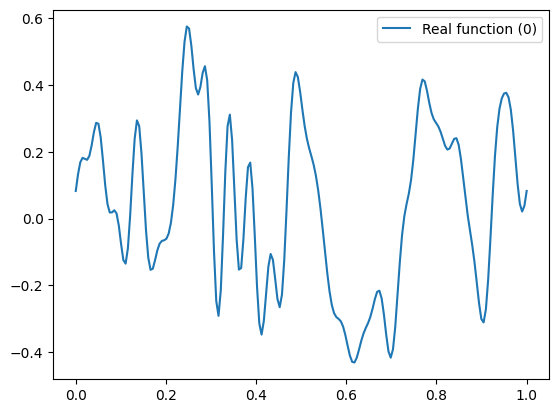

In [5]:
problem_basis[0].plot(res=200)

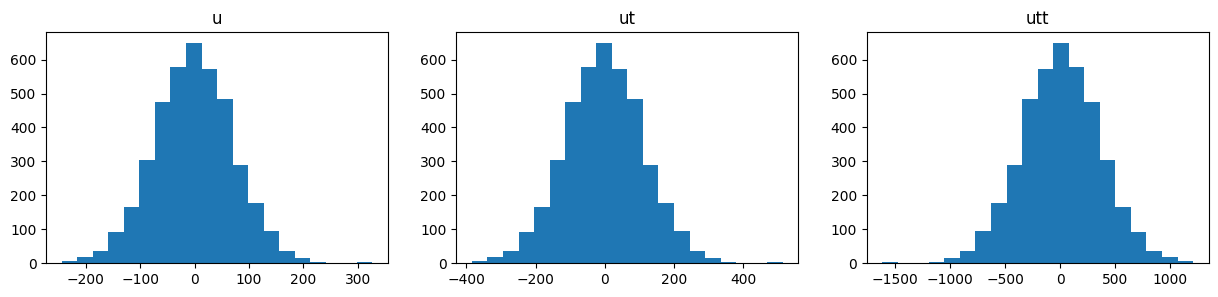

In [6]:
def visualize_dist_coeff(dim=0):
    fig, axs = plt.subplots(1, 3, figsize=[15,3])

    axs[0].hist(u_coeff_clean[:,dim].real, bins = 20)
    axs[0].set_title("u")
    axs[1].hist(ut_coeff_clean[:,dim].imag/8, bins = 20)
    axs[1].set_title("ut")
    axs[2].hist(utt_coeff_clean[:,dim].real/32, bins = 20)
    axs[2].set_title("utt")
    plt.show()
visualize_dist_coeff(2)

{'shape': torch.Size([4001, 900]),
 'r2': tensor(0.9994),
 'mse': tensor(2.7816),
 'PSNR': tensor(41.4170)}

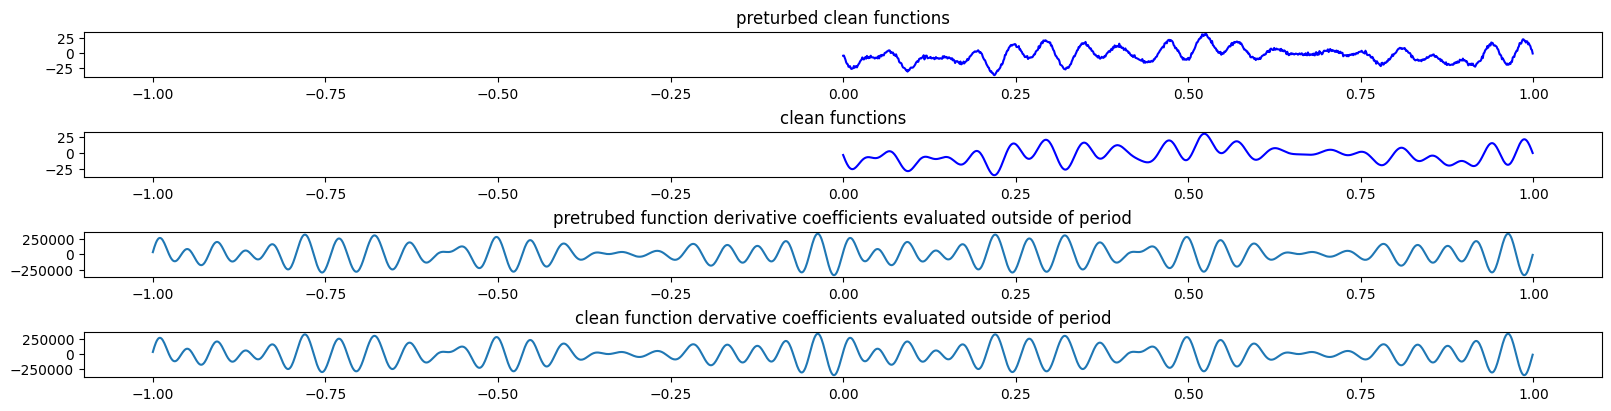

In [7]:
period = 1.0
periods = [period] * len(modes)
sample_freq = 900.0
sample_step = period / sample_freq
t = torch.arange(0, 1, sample_step)
tmp = [t for i in range(len(modes))]
tt = torch.meshgrid(tmp, indexing="ij")
tt_flat = [t.flatten() for t in tt]
points_tt = torch.concat([t.unsqueeze(-1) for t in tt_flat], 1)
u_basis = FourierBasis(u_coeff_clean, periods=periods)
# ut_basis = FourierBasis(ut_coeff_clean, periods)
# utt_basis = FourierBasis(utt_coeff_clean, periods)
# points_tt.requires_grad_()
u_clean = u_basis(points_tt).real
ut_clean = torch.gradient(u_clean, spacing=tt_flat, dim=1)[0]
# ut_clean = ut_basis(points_tt).real
utt_clean = torch.gradient(ut_clean, spacing=tt_flat, dim=1)[0]

# points_tt.requires_grad_(False)
# utt_clean = utt_basis(points_tt).real
noise_ratio = 0.1
u = u_clean + torch.randn_like(u_clean) * noise_ratio * u_clean.std()
ut = ut_clean + torch.randn_like(ut_clean) * noise_ratio * ut_clean.std()
utt = utt_clean + torch.randn_like(utt_clean) * noise_ratio * utt_clean.std()
u_coeff = resize_modes(FourierBasis.transform(u),modes)
ut_coeff = resize_modes(FourierBasis.transform(u),modes)
utt_coeff = resize_modes(FourierBasis.transform(utt),modes)
u_shape = u.shape

u_coeff_clean = resize_modes(FourierBasis.transform(u_clean), modes)
ut_coeff_clean = u_coeff_clean * 2j * torch.pi * k.T
utt_coeff_clean = ut_coeff_clean * 2j * torch.pi * k.T  # d2f/dt2


def signal_stats():
    # u_real, u_clean_real = to_real_coeff(u), to_real_coeff(u_clean)
    u_real, u_clean_real = (
        to_real_coeff(resize_modes(u_coeff, modes)),
        to_real_coeff(u_coeff_clean),
    )
    r2 = r2_score(u_real, u_clean_real)
    MSE = mean_squared_error(u_real, u_clean_real)
    stats = {
        "shape": u_shape,
        "r2": r2,
        "mse": MSE,
        "PSNR": 20 * u_clean_real.max().log10() - 10 * MSE.pow(2).log10(),
    }
    display(stats)


signal_stats()


def tmp_plot():
    n = 2
    points = torch.arange(-1, 1, sample_step)
    utt_eval = FourierBasis(utt_coeff[n, None], periods=periods)(
        points.view((-1, 1))
    )
    utt_clean_eval = FourierBasis(utt_coeff_clean[n, None], periods=periods)(
        points.view((-1, 1))
    )
    plt.figure(figsize=(16, 4), constrained_layout=True)
    ax1 = plt.subplot(411)
    plt.plot(t, u[n].real, color="b")
#     plt.plot(t, utt[n].real, color="k")
    plt.title("preturbed clean functions")
    plt.subplot(412, sharex=ax1)
    plt.plot(t, u_clean[n].real, color="b")
    # plt.plot(t, utt_clean[n].real, color="k")
    plt.title("clean functions")
    plt.subplot(413, sharex=ax1)
    plt.plot(points, utt_eval[0].real)
    plt.title("pretrubed function derivative coefficients evaluated outside of period")
    plt.subplot(414, sharex=ax1)
    plt.plot(points, utt_clean_eval[0].real)
    plt.title("clean function dervative coefficients evaluated outside of period")
    plt.show()


tmp_plot()

In [8]:
u_coeff

tensor([[ -82.5572+0.0000j,  137.0501+107.6211j,   66.5014-148.4747j,
          ...,   48.1271+86.2221j,   66.5026+148.4741j,
          137.0423-107.6335j],
        [  56.6794+0.0000j,  -65.0794-48.0435j,    4.3094+34.6788j,
          ...,  -31.9660-81.2436j,    4.3085-34.6781j,
          -65.0759+48.0436j],
        [-139.9910+0.0000j, -177.4134+32.3899j,   57.1536+1.6026j,
          ...,   45.0062-43.4205j,   57.1526-1.6020j,
         -177.4177-32.3949j],
        ...,
        [ 186.7667+0.0000j, -133.8250+13.8294j,   -0.5891-20.6630j,
          ...,    9.8675-142.6568j,   -0.5906+20.6637j,
         -133.8136-13.8339j],
        [  88.3158+0.0000j,  -67.7452+46.2644j,   55.2176-46.5598j,
          ...,  -18.2762+86.5785j,   55.2168+46.5587j,
          -67.7415-46.2631j],
        [-129.0573+0.0000j, -143.2896-54.8655j,  -12.0597-88.9113j,
          ...,  -55.1366-11.2346j,  -12.0603+88.9121j,
         -143.2924+54.8589j]])

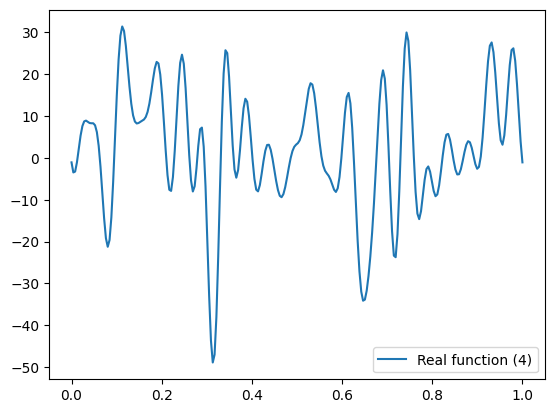

In [10]:
u_basis.plot(i=4)
plt.show()

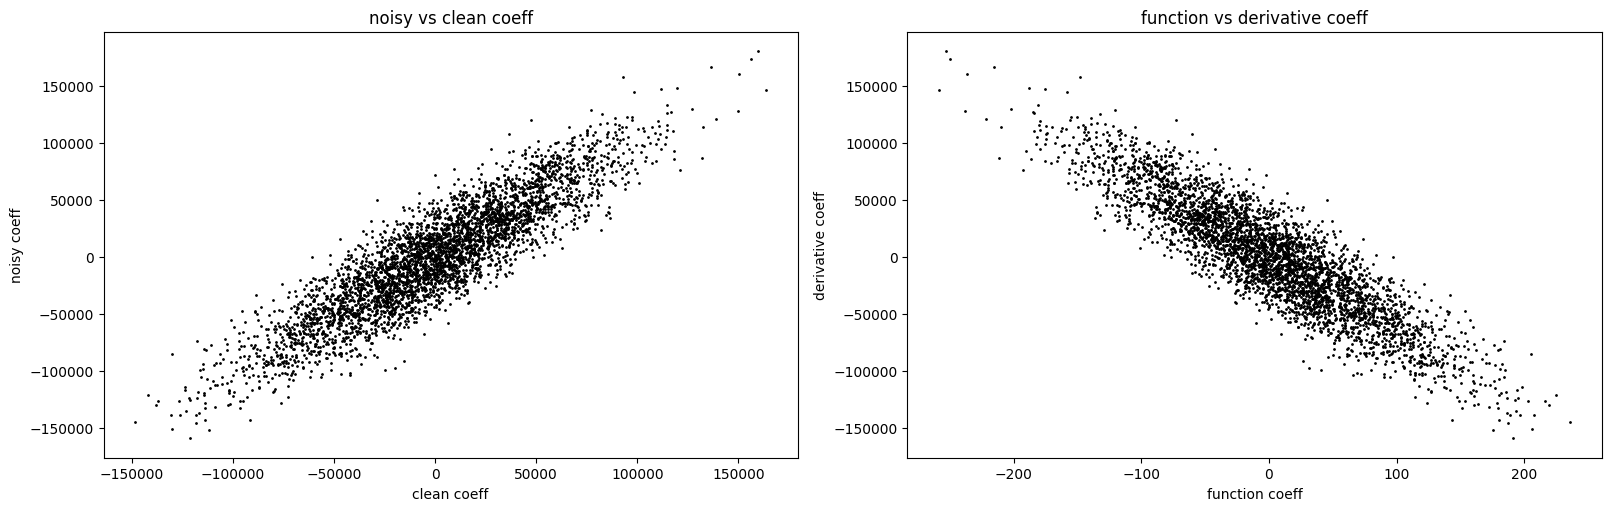

In [11]:
def plot_coeff_corr(n, prop_func = lambda x: x.real):
    plt.figure(figsize=(16,5), constrained_layout=True)
    plt.subplot(121)
    plt.title("noisy vs clean coeff")
    plt.xlabel("clean coeff")
    plt.ylabel("noisy coeff")
    plt.plot(prop_func(utt_coeff_clean[:,n]),prop_func(utt_coeff[:,n]), 'ko', ms=1)

    plt.subplot(122)
    plt.title("function vs derivative coeff")
    plt.plot(prop_func(u_coeff[:,n]),prop_func(utt_coeff[:,n]), 'ko', ms=1)
    plt.xlabel("function coeff")
    plt.ylabel("derivative coeff")
    plt.show()

plot_coeff_corr(4, prop_func=lambda x: x.real)

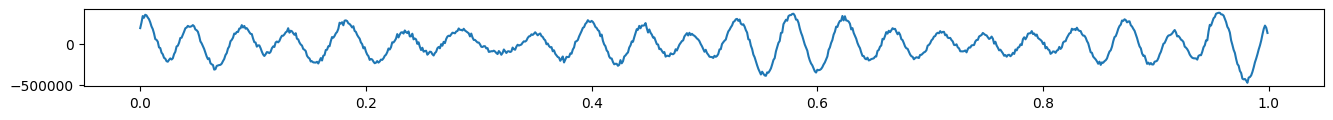

In [13]:
from torch.utils.data import TensorDataset, random_split

input_data = (utt, utt_coeff)
output_data = (u, u_coeff)
dataset = TensorDataset(*input_data, *output_data)
dataset_train, dataset_test = random_split(
    dataset, (0.8, 0.2), generator=torch.Generator().manual_seed(42)
)
# f_train, f_coeff_train, u_train, u_coeff_train = dataset_train[:]
# f_test, f_coeff_test, u_test, u_coeff_test = dataset_test[:]
# f_train.shape, f_coeff_train.shape, u_coeff_train.shape
plt.figure(figsize=(16, 1))
plt.plot(points_tt[:], dataset[0][0])
plt.show()

In [14]:
f_train, f_coeff_train, u_train, u_coeff_train = dataset_train[:]
# f_input_train = f_train
scaler = StandardScaler().fit((f_train, f_coeff_train))
f_train, f_coeff_train = scaler.transform((f_train, f_coeff_train))

f_input_train = to_real_coeff(f_coeff_train)
# f_input_train = (f_coeff_train.abs())

f_test, f_coeff_test, u_test, u_coeff_test = dataset_test[:]
f_test, f_coeff_test = scaler.transform((f_test, f_coeff_test))
# f_input_test = f_test
f_input_test = to_real_coeff(f_coeff_test)
# f_input_test = (f_coeff_test.abs())
model = SpectralSVR(
    FourierBasis(periods=periods),
    # C=1.227,
    C=1.00,
    # sigma=1.0,
    # sigma=f_input_train.var(0).median().multiply(f_input_train.shape[1]).pow(0.5),
    sigma=f_input_train.var(0).sum().pow(0.5) * 1.0,
    # sigma=70.0,
    # kernel="linear",
    kernel="rbf",
    batch_size_func=lambda dims: 10000000,
    # verbose="LSSVR",
)
# model.train(f_input_train, u_coeff_train * 900/200, list(u_coeff_zeroed.shape[1:]))
model.train(f_input_train, u_coeff_train).test(f_input_test, u_coeff_test)

{'spectral': {'mse': 602.5164794921875,
  'rmse': 24.54621124267578,
  'mae': 11.657814025878906,
  'r2': 0.8901386260986328,
  'smape': 0.3604346811771393,
  'rse': 0.10986143350601196,
  'rrse': 0.20937900245189667,
  'pred_nan_sum': 0},
 'function value': {'mse': 24.102785110473633,
  'rmse': 4.909458637237549,
  'mae': 3.9066827297210693,
  'r2': 0.8773515820503235,
  'smape': 0.6271081566810608,
  'rse': 0.12264837324619293,
  'rrse': 0.35001254081726074,
  'pred_nan_sum': 0}}

In [15]:
u_pred = model.forward(f_input_test, points_tt)
u_coeff_pred = to_complex_coeff(model.svr.predict(f_input_test)) 
# u_coeff_pred = u_coeff_pred * u_coeff_test.std() / u_coeff_pred.std()
# u_coeff_pred = to_complex_coeff(model.svr.predict(f_input_test))
u_pred_basis = FourierBasis(u_coeff_pred, periods=periods)
u_basis_pred = u_pred_basis(points_tt)
# u_pred = lssvr.predict(points_tt).T
u_pred.shape, model

(torch.Size([800, 900]),
 <skripsi_program.model.SpectralSVR.SpectralSVR at 0x23953ec5120>)

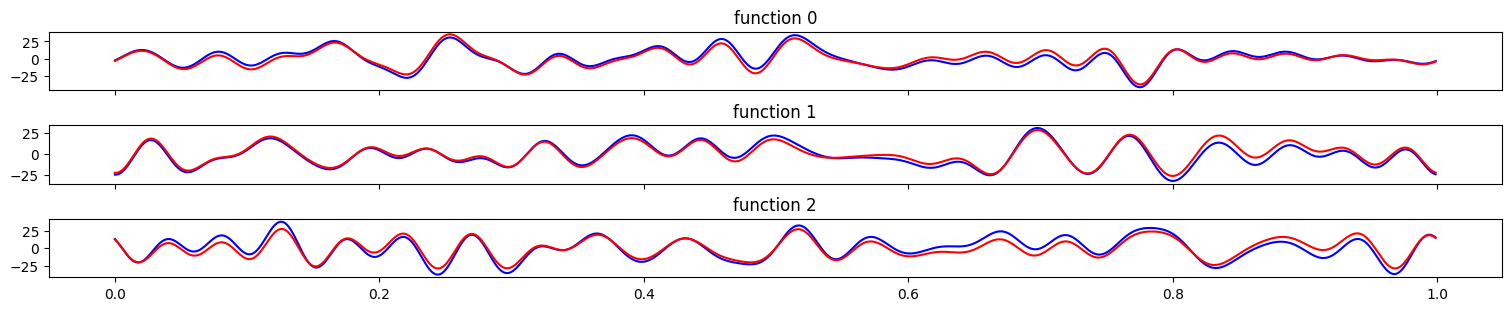

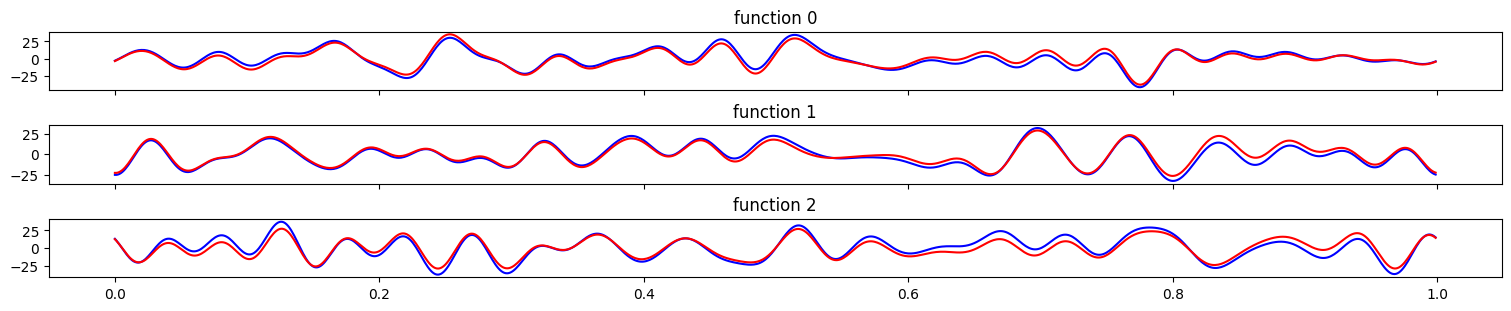

In [17]:
# do this because forward in SpectralSVR isn't scaling invariant
u_test_eval = FourierBasis(u_coeff_test)(points_tt).real
# u_coeff_clean_scaled = u_coeff_clean
# u_coeff_clean_scaled = scaler.get_subset_scaler([-1]).transform((u_coeff_clean,))[0][dataset_test.indices]
u_coeff_clean_eval = FourierBasis(u_coeff_clean[dataset_test.indices])(points_tt).real


def plot_funcs(u_pred: torch.Tensor, u: torch.Tensor, n=6):
    # line_styles = ["solid", "dotted", "dashed", "dashdot"]
    fig, axs = plt.subplots(n, 1, figsize=[15, n], constrained_layout=True, sharex=True)
    for i in range(n):
        # axs[i%2, i//2].scatter(points_sampled[:,1], u_sampled[i, :])
        # axs[i%2, i//2].plot(t, u_basis_pred[i].real, color="black")
        # axs[i].plot(t, u_test[i].real, color="blue")
        axs[i].plot(t, u[i].real, color="blue")
        axs[i].plot(t, u_pred[i].real, color="red")
        axs[i].set_title(f"function {i}")

    plt.show()


# plot_funcs(u_pred.real, u_test_eval.real, 2)
# plot_funcs(u_pred, u_coeff_clean_eval, 2)
plot_funcs(u_basis_pred.real, u_test_eval.real, 3)
plot_funcs(u_basis_pred.real, u_coeff_clean_eval, 3)

In [18]:
u_coeff_train[:,0]

tensor([ -46.5427+0.j,   23.9707+0.j,   62.6470+0.j,  ..., -115.9445+0.j,
         218.2948+0.j,  -33.7902+0.j])

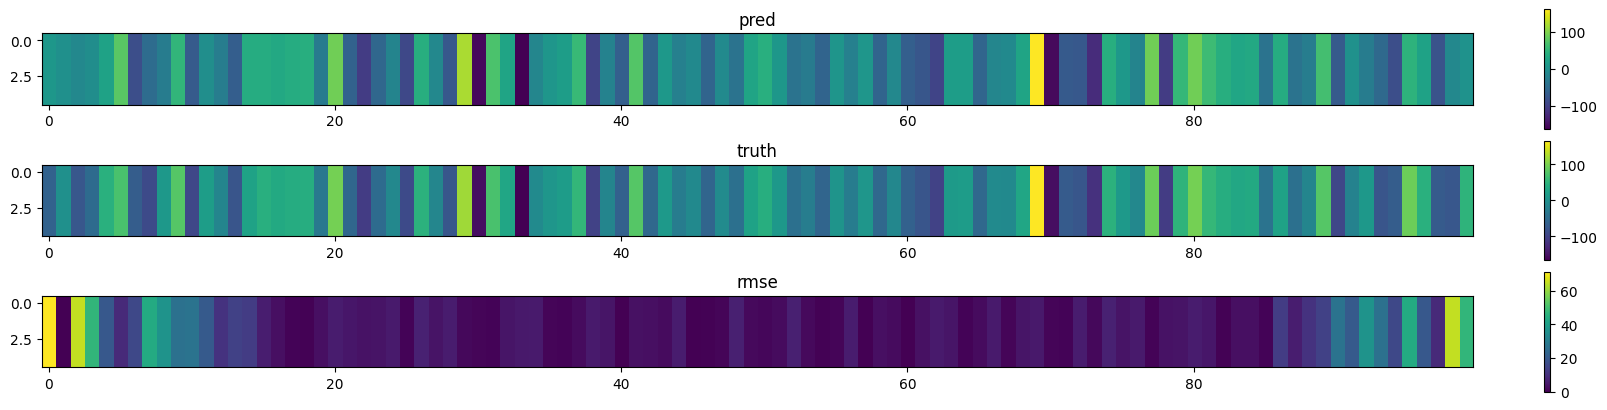

In [19]:
def plot_coeffs(coeff_pred: torch.Tensor, coeff: torch.Tensor, n=0):
    # k = FourierBasis.waveNumber(coeff_pred.shape[1]).T[0].numpy() * 1.
    # print(k.shape)
    # print(coeff_pred.shape)
    height = coeff_pred.shape[1]//25 + 1
    plt.figure(figsize=(16, 4), constrained_layout=True)
    plt.subplot(311)
    plt.imshow(coeff_pred[n].view((1, -1)).expand((height,-1)))
    plt.title("pred")
    plt.colorbar()
    plt.subplot(312)
    plt.imshow(coeff[n].view((1, -1)).expand((height,-1)))
    plt.title("truth")
    plt.colorbar()
    plt.subplot(313)
    plt.imshow(
        mean_squared_error(
            coeff_pred[n, None],
            coeff[n, None],
            squared=False,
            num_outputs=coeff.shape[1],
        ).view((1, -1)).expand((height,-1))
    )
    plt.title("rmse")
    plt.colorbar()

    plt.show()


plot_coeffs(to_real_coeff(u_coeff_pred), to_real_coeff(u_coeff_test), 1)

In [23]:
f_test, f_coeff_test, u_test, u_coeff_test = dataset_test[0:10]
u_test_basis = FourierBasis(u_coeff_test, periods=periods)
u_inv = u_test_basis(points_tt).real
inverse_pred = model.inverse(u_inv, points_tt, epochs=500, lr=1e-3, loss_fn=mean_squared_error, gain=1e-4).detach()


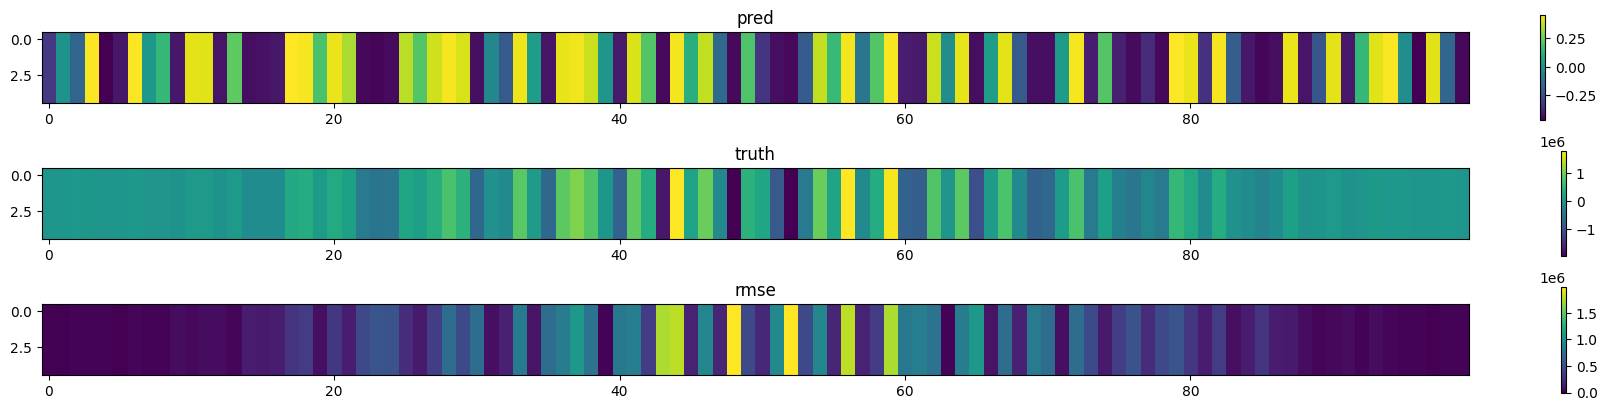

In [24]:
f_truth = to_real_coeff(f_coeff_test)
# f_truth = FourierBasis(periods=periods)(points_tt, f_coeff_test, periods=periods,modes=modes).real
# plot_funcs(inverse_pred, f_truth, n=10)
plot_coeffs(inverse_pred, f_truth)

In [22]:
preds = inverse_pred.real
targets = f_truth.real
(
    mean_squared_error(preds, targets),
    r2_score(preds, targets),
    mean_absolute_error(preds, targets),
    symmetric_mean_absolute_percentage_error(preds, targets),
    f_truth.shape,
)


(tensor(4.8629e+11),
 tensor(-0.1180),
 tensor(423047.5938),
 tensor(1.9824),
 torch.Size([10, 100]))